# Template used to test a model locally:

### Outline: 

- Import the Dataset using the correct function

- Use the function transformers to do the feature engineering - ```Please Comment any step that you have changed versus the best submission```

- Retrieve the transformed X_train and run ydata_profiling to find insights

- Create pipeline

- Run CV to get a baseline RMSE score

- Print the most important hyperparameters & run the Optuna training 

- Rerun the pipeline to see the impact - ```Please share any relevant information here```

- Update the script with the final model and test submission

## Example with Best Score Script using PCA using interpolate instead of ffill + 

### Import the Dataset

In [1]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import holidays
from lockdowndates.core import LockdownDates
import haversine as hs
from datetime import datetime
from meteostat import Point, Hourly
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from skrub import TableVectorizer
import numpy as np
from pathlib import Path
from datetime import datetime
from sklearn.decomposition import PCA
from meteostat import Point, Hourly

In [2]:
greves = pd.read_csv('/Users/ghalichraibi/Desktop/DATA Challenge/Data_Challenge/data/mouvements-sociaux-depuis-2002.csv',sep=";")
greves = pd.Series(greves['Date']).reset_index(drop=True)
greves

0     2021-11-17
1     2021-08-05
2     2021-07-01
3     2021-03-08
4     2021-02-04
5     2020-09-17
6     2020-02-27
7     2020-02-20
8     2020-02-13
9     2020-02-06
10    2020-01-29
11    2020-01-24
12    2020-01-23
13    2020-01-22
14    2020-01-21
15    2020-01-20
16    2020-01-19
17    2020-01-18
18    2020-01-17
19    2020-01-16
20    2020-01-15
21    2020-01-14
22    2020-01-13
23    2020-01-12
24    2020-01-11
25    2020-01-10
26    2020-01-09
27    2020-01-08
28    2020-01-07
29    2020-01-06
30    2020-01-05
31    2020-01-04
32    2020-01-03
33    2020-01-02
34    2020-01-01
Name: Date, dtype: object

In [3]:
def _read_data():
    _target_column_name = 'log_bike_count'
    data = pd.read_parquet('/Users/ghalichraibi/Desktop/DATA Challenge/Data_Challenge/data/train.parquet')
    # Sort by date first, so that time based cross-validation would produce correct results
    data = data.sort_values(["date", "counter_name"])
    y_array = data[_target_column_name].values
    X_df = data.drop([_target_column_name, "bike_count"], axis=1)
    return X_df, y_array

In [4]:
X_train, y_train = _read_data()
X_final = pd.read_parquet('/Users/ghalichraibi/Desktop/DATA Challenge/Data_Challenge/data/final_test.parquet')

### Function Transformers

In [5]:
# Encode Date with Fourrier + Covid + Holidays (To test Perf With Weekend + Holidays)

def _encode_dates(X):
    X = X.copy()  # modify a copy of X
    # Encode the date information from the DateOfDeparture columns
    X.loc[:, "year"] = X["date"].dt.year
    X.loc[:, "date_ws"] = X["date"].dt.date.astype('datetime64[ns]') # To be used for merging
    X.loc[:, "month"] = X["date"].dt.month
    X.loc[:, "day"] = X["date"].dt.day
    X.loc[:, "weekday"] = X["date"].dt.weekday
    X.loc[:, "hour"] = X["date"].dt.hour
    X.loc[:, "week_of_year"] = X["date"].dt.isocalendar().week
    X.loc[:, "season"] = X["week_of_year"].apply(lambda w: (w // 13) % 4 + 1)
    X.loc[: ,'weekend'] = X['date'].apply(lambda x: x.weekday() >= 5).astype(int)

    # Add the column corresponding to holidays
    fr_holidays = holidays.FR(years=X["year"].unique().tolist())
    X.loc[: ,'holidays'] = X['date'].apply(lambda x: x in fr_holidays).astype(int)

    # Add covid restrictions
    ld = LockdownDates("France", "2020-09-01", "2022-01-01", ("stay_at_home", "masks"))
    lockdown_dates = ld.dates()
    X = X.reset_index().merge(lockdown_dates['france_stay_at_home'], how='left', left_on='date_ws', right_index=True).set_index('index')
    
    # Month
    months_in_year = 12
    X['sin_month'] = np.sin(2*np.pi*X.month/months_in_year)
    X['cos_month'] = np.cos(2*np.pi*X.month/months_in_year)
    X.drop('month', axis=1, inplace=True)
    
    # Day
    day_in_month = 31
    X['sin_day'] = np.sin(2*np.pi*X.day/day_in_month)
    X['cos_day'] = np.cos(2*np.pi*X.day/day_in_month)
    X.drop('day', axis=1, inplace=True)
    
    # Weekday
    day_in_week = 7
    X['sin_weekday'] = np.sin(2*np.pi*X.weekday/day_in_week)
    X['cos_weekday'] = np.cos(2*np.pi*X.weekday/day_in_week)
    X.drop('weekday', axis=1, inplace=True)
    
    # Hour
    hours_in_day = 24
    X['sin_hour'] = np.sin(2*np.pi*X.hour/hours_in_day)
    X['cos_hour'] = np.cos(2*np.pi*X.hour/hours_in_day)
    X.drop('hour', axis=1, inplace=True)
    
    # Week of year
    weeks_in_year = 52
    X['sin_weekyear'] = np.sin(2*np.pi*X.week_of_year/weeks_in_year)
    X['cos_weekyear'] = np.cos(2*np.pi*X.week_of_year/weeks_in_year)
    
    # Season
    seasons_in_year = 4
    X['sin_season'] = np.sin(2*np.pi*X.season/seasons_in_year)
    X['cos_season'] = np.cos(2*np.pi*X.season/seasons_in_year)
    X.drop('season', axis=1, inplace=True)

    return X

In [6]:
# Retrieve the closest transport station // Test with number of stations in a radius (Categorical)

def _closest_transport(X): 
    column_names = ['longitude', 'latitude', 'station_name']  # Replace with your actual column names
    idf_stations = pd.read_csv('/Users/ghalichraibi/Desktop/DATA Challenge/Data_Challenge/data/Stations_IDF.csv', delimiter=';', header=None, names=column_names)

    X = X.copy()
    # Create an empty DataFrame to store the results
    result_df = pd.DataFrame(columns=['counter_id', 'closest_metro_distance'])

    # Iterate over unique counter_ids in X
    for counter_id in X['counter_id'].unique():
        coordinates_counter = (X.loc[X['counter_id'] == counter_id, 'latitude'].values[0],
                               X.loc[X['counter_id'] == counter_id, 'longitude'].values[0])

        # Calculate distances to all metro stations
        distances = []
        for _, station_row in idf_stations.iterrows():
            coordinates_station = (station_row['latitude'], station_row['longitude'])
            distance = hs.haversine(coordinates_counter, coordinates_station)
            distances.append(distance)

        # Get the k closest distances
        closest_distance = sorted(distances)[0]

        # Append to the result DataFrame
        new_df = pd.DataFrame({'counter_id': [counter_id], 'closest_metro_distance': [closest_distance]})
        result_df = ( new_df if result_df.empty else pd.concat([result_df, new_df]) )
    
    result_df = result_df.set_index('counter_id')
    X = X.reset_index().merge(result_df['closest_metro_distance'], how='left', left_on='counter_id', right_index=True).set_index('index')
        
    return X

In [7]:
def _count_stations(X): 

    X = X.copy()
    # Create an empty DataFrame to store the results
    column_names = ['longitude', 'latitude', 'station_name']  # Replace with your actual column names
    idf_stations = pd.read_csv('/Users/ghalichraibi/Desktop/DATA Challenge/Data_Challenge/data/Stations_IDF.csv', delimiter=';', header=None, names=column_names)
    result_df = pd.DataFrame(columns=['counter_id', 'num_stations_within_radius'])

    # Iterate over unique counter_ids in X
    for counter_id in X['counter_id'].unique():
        coordinates_counter = (X.loc[X['counter_id'] == counter_id, 'latitude'].values[0],
                               X.loc[X['counter_id'] == counter_id, 'longitude'].values[0])

        # Count stations within the given radius
        num_stations_within_radius = 0
        for _, station_row in idf_stations.iterrows():
            coordinates_station = (station_row['latitude'], station_row['longitude'])
            distance = hs.haversine(coordinates_counter, coordinates_station)

            if distance <= 0.4:
                num_stations_within_radius += 1

        # Append to the result DataFrame
        result_df = pd.concat([result_df, pd.DataFrame({'counter_id': [counter_id], 'num_stations_within_radius': [num_stations_within_radius]})])

    result_df = result_df.set_index('counter_id')
    X = X.reset_index().merge(result_df['num_stations_within_radius'], how='left', left_on='counter_id', right_index=True).set_index('index')
    X['num_stations_within_radius'] = X['num_stations_within_radius'].astype(int)

    return X

In [8]:
# Add Weather Data //  PCA + Drop all cols + ffill

def _add_weather_data(X):
    X = X.copy()
    dfs = []

    for counter_id in X['counter_id'].unique():
        # Get the coordinates of the counter
        coordinates_counter = (
            X.loc[X['counter_id'] == counter_id, 'latitude'].values[0],
            X.loc[X['counter_id'] == counter_id, 'longitude'].values[0]
        )

        # Create a Point object with the counter's coordinates
        counter_point = Point(*coordinates_counter)

        # Define the time range (start and end dates)
        start = datetime(2020, 8, 1)
        end = datetime(2022, 1, 1)

        # Create a Hourly object and fetch the weather data
        weather_data = Hourly(counter_point, start, end).interpolate().fetch()
        selected_columns = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres', 'snow', 'coco']
        weather_data = weather_data[selected_columns].shift(-1)

        # Append counter_id to the weather_data DataFrame
        weather_data['counter_id'] = counter_id

        # Append the DataFrame to the list
        dfs.append(weather_data)

    # Concatenate all DataFrames into a single result_df
    result_df = pd.concat([df for df in dfs if not df.empty])
    
    # Convert 'time' index to 'date' column for merging
    result_df['date'] = result_df.index
    result_df['date'] = pd.to_datetime(result_df['date'])
    
    # Merge the result DataFrame with the original DataFrame on 'counter_id' and 'date'
    X = X.reset_index().merge(result_df, how='left', on=['counter_id', 'date']).set_index('index')

    X['extreme_condition'] = (
        (X['temp'] < X['temp'].quantile(0.015)) |
        (X['prcp'] > X['prcp'].quantile(0.98)) |
        (X['wspd'] > X['wspd'].quantile(0.99)) |
        (X['snow'] > X['snow'].quantile(0.9925))
    ).astype(int)

    return X.drop(columns=["date", "counter_name", "site_id", "site_name", 
                           "counter_installation_date", "counter_technical_id",
                           "longitude", "latitude", "date_ws", "coordinates", "snow"])

### Call all functions on X train, concatenate with y_train and run ydata_profiling

In [9]:
# Please don't change the X_train_encode to not overwrite the initial dataset that will be used later for the modelling

X_train_encoded = _encode_dates(X_train)
X_train_encoded = _closest_transport(X_train_encoded)
X_train_encoded = _count_stations(X_train_encoded)
X_train_encoded = _add_weather_data(X_train_encoded)

Fetching lockdown dates...
Fetched lockdown dates for: France


In [10]:
# Do the necessary changes to proceed to ydata_profiling

y_train_transformed = pd.Series(y_train).reset_index(drop=True)

concatenated_df = pd.concat([X_train_encoded.reset_index(drop=True), y_train_transformed], axis=1)

In [11]:
concatenated_df.head()

counter_id  year  week_of_year  weekend  holidays  \
0  100049407-353255860  2020            36        0         0   
1  100049407-353255859  2020            36        0         0   
2  100036719-104036719  2020            36        0         0   
3  100036719-103036719  2020            36        0         0   
4  100063175-353277233  2020            36        0         0   

  france_stay_at_home  sin_month     cos_month   sin_day  cos_day  ...  dwpt  \
0                 0.0       -1.0 -1.836970e-16  0.201299  0.97953  ...   9.4   
1                 0.0       -1.0 -1.836970e-16  0.201299  0.97953  ...   9.4   
2                 0.0       -1.0 -1.836970e-16  0.201299  0.97953  ...   9.4   
3                 0.0       -1.0 -1.836970e-16  0.201299  0.97953  ...   9.4   
4                 0.0       -1.0 -1.836970e-16  0.201299  0.97953  ...   9.4   

   rhum  prcp   wdir  wspd  wpgt    pres  coco  extreme_condition         0  
0  79.0   0.0  290.0   3.6   9.3  1019.9   1.0                  0  1.609438  
1  79.0   0.0  290.0   3.6   9.3  1019.9   1.0                  0  1.386294  
2  79.0   0.0  290.0   3.6   9.3  1019.9   1.0                  0  0.000000  
3  79.0   0.0  290.0   3.6   9.3  1019.9   1.0                  0  0.693147  
4  79.0   0.0  290.0   3.6   9.3  1019.9   5.0                  0  2.079442  

[5 rows x 31 columns]

In [12]:
#import ydata_profiling

#concatenated_df.profile_report()

In [13]:
# Add the column corresponding to holidays
fr_holidays = holidays.FR(years=concatenated_df["year"].unique().tolist())

fr_holidays = pd.Series(fr_holidays)

fr_holidays

2020-01-01           Jour de l'an
2020-05-01        Fête du Travail
2020-05-08    Fête de la Victoire
2020-07-14         Fête nationale
2020-11-11              Armistice
2020-04-13        Lundi de Pâques
2020-06-01     Lundi de Pentecôte
2020-05-21              Ascension
2020-08-15             Assomption
2020-11-01              Toussaint
2020-12-25                   Noël
2021-01-01           Jour de l'an
2021-05-01        Fête du Travail
2021-05-08    Fête de la Victoire
2021-07-14         Fête nationale
2021-11-11              Armistice
2021-04-05        Lundi de Pâques
2021-05-24     Lundi de Pentecôte
2021-05-13              Ascension
2021-08-15             Assomption
2021-11-01              Toussaint
2021-12-25                   Noël
dtype: object

**Note on the correlation matrix that some of the cos/sin features that we derive are correlated between each other. Try to keep only certain of them and keep the other as categories** 

### Create Pipeline and CV

In [14]:
def get_estimator():
    date_encoder = FunctionTransformer(_encode_dates)
    transport_encoder = FunctionTransformer(_closest_transport)
    count_transp_encoder = FunctionTransformer(_count_stations)
    weather_encoder = FunctionTransformer(_add_weather_data)
    
    date_cols = ["sin_month", "sin_day", "sin_hour", "sin_weekday", "sin_season", "sin_weekyear",
                 "cos_month", "cos_day", "cos_hour", "cos_weekday", "cos_season", "cos_weekyear"]

    categorical_cols = ["counter_id", "holidays", "france_stay_at_home", "year", "extreme_condition"]
    numerical_cols = ["closest_metro_distance", "num_stations_within_radius"]
    weather_cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres', 'coco']

    preprocessor = ColumnTransformer(
        [
            ("date", 'passthrough', date_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
            ("num", 'passthrough', numerical_cols),
            ("pca_weather", make_pipeline(StandardScaler(), PCA(n_components=5)), weather_cols),
            ("drop_weather", 'drop', weather_cols)
        ]
    )

    regressor = CatBoostRegressor()

    pipe = make_pipeline(date_encoder, transport_encoder, count_transp_encoder, weather_encoder,
                         preprocessor, regressor)

    return pipe

In [15]:
pipe = get_estimator()

pipe.fit(X_train, y_train)

cv = TimeSeriesSplit(n_splits=5)

# When using a scorer in scikit-learn it always needs to be better when smaller, hence the minus sign.
scores = cross_val_score(
    pipe, X_train, y_train, cv=cv, scoring="neg_root_mean_squared_error"
)
print("RMSE: ", scores)
print(f"RMSE (all folds): {-scores.mean():.3} ± {(-scores).std():.3}")

Fetching lockdown dates...
Fetched lockdown dates for: France
Learning rate set to 0.109189
0:	learn: 1.5447028	total: 89ms	remaining: 1m 28s
1:	learn: 1.4467406	total: 111ms	remaining: 55.2s
2:	learn: 1.3632362	total: 131ms	remaining: 43.6s
3:	learn: 1.2921857	total: 152ms	remaining: 37.9s
4:	learn: 1.2310839	total: 174ms	remaining: 34.7s
5:	learn: 1.1757851	total: 199ms	remaining: 33s
6:	learn: 1.1280204	total: 221ms	remaining: 31.3s
7:	learn: 1.0894832	total: 246ms	remaining: 30.4s
8:	learn: 1.0560715	total: 271ms	remaining: 29.8s
9:	learn: 1.0262718	total: 293ms	remaining: 29s
10:	learn: 1.0014834	total: 312ms	remaining: 28.1s
11:	learn: 0.9797956	total: 331ms	remaining: 27.2s
12:	learn: 0.9619122	total: 347ms	remaining: 26.3s
13:	learn: 0.9462088	total: 364ms	remaining: 25.7s
14:	learn: 0.9301038	total: 382ms	remaining: 25.1s
15:	learn: 0.9138398	total: 401ms	remaining: 24.7s
16:	learn: 0.9013518	total: 421ms	remaining: 24.3s
17:	learn: 0.8898524	total: 440ms	remaining: 24s
18:	le

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

date_cols = ["sin_month", "sin_day", "sin_hour", "sin_weekday", "sin_season", "sin_weekyear",
            "cos_month", "cos_day", "cos_hour", "cos_weekday", "cos_season", "cos_weekyear"]

categorical_cols = ["counter_id", "holidays", "france_stay_at_home", "year", "extreme_condition"]
numerical_cols = ["closest_metro_distance", "num_stations_within_radius"]
weather_cols = ['temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd', 'wpgt', 'pres', 'coco']

import pandas as pd

# Apply function transformers
X_train_date_encoded = pipe.named_steps['functiontransformer-1'].transform(X_train)
X_train_transport_encoded = pipe.named_steps['functiontransformer-2'].transform(X_train_date_encoded)
X_train_count_transp_encoded = pipe.named_steps['functiontransformer-3'].transform(X_train_transport_encoded)
X_train_w_encoded = pipe.named_steps['functiontransformer-4'].transform(X_train_count_transp_encoded)

# Transform the data using the column transformer
X_train_transformed = pipe.named_steps['columntransformer'].transform(X_train_w_encoded)

# Print the shape of X_train_transformed
print("X_train_transformed shape:", X_train_transformed.shape)

# Attempt to create a DataFrame with specific column names
try:
    X_train_transformed_df = pd.DataFrame(
        data=X_train_transformed.toarray(),  # Convert the sparse matrix to a dense array
        columns=date_cols + categorical_cols + numerical_cols + ['pca_weather_{}'.format(i) for i in range(5)]
)
    print("X_train_transformed_df shape:", X_train_transformed_df.shape)
except Exception as e:
    print("Error creating DataFrame:", e)

# Concatenate the transformed features and the target variable
data_with_target = pd.concat([X_train_transformed_df, pd.DataFrame({'target': y_train})], axis=1)

import seaborn as sns

fig = plt.figure(figsize=(36,36), dpi = 480)
sns.heatmap(data_with_target.corr(), annot = True, fmt = '.2f')

Fetching lockdown dates...
Fetched lockdown dates for: France
X_train_transformed shape: (496827, 83)
Error creating DataFrame: Shape of passed values is (496827, 83), indices imply (496827, 24)


<Axes: >

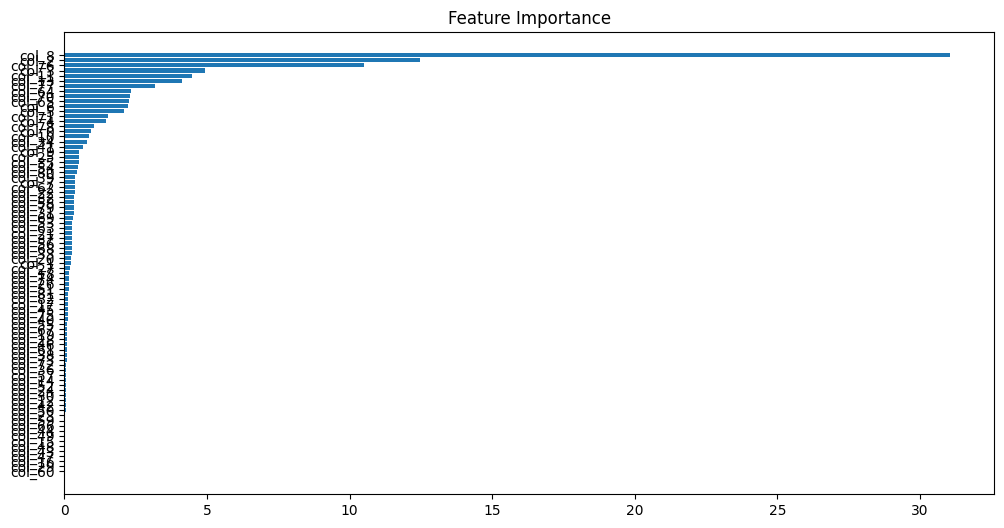

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_train_transformed_df is a DataFrame
feature_importance = pipe.named_steps['catboostregressor'].feature_importances_
sorted_idx = np.argsort(feature_importance)

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')

# Label the y-axis with column names
ax.set_yticks(range(len(sorted_idx)))
ax.set_yticklabels(X_train_transformed_df.columns[sorted_idx])

plt.title('Feature Importance')
plt.show()


In [22]:
X_train_transformed_df

col_0     col_1     col_2     col_3  col_4     col_5         col_6  \
0        -1.0  0.201299  0.258819  0.781831   -1.0 -0.935016 -1.836970e-16   
1        -1.0  0.201299  0.258819  0.781831   -1.0 -0.935016 -1.836970e-16   
2        -1.0  0.201299  0.258819  0.781831   -1.0 -0.935016 -1.836970e-16   
3        -1.0  0.201299  0.258819  0.781831   -1.0 -0.935016 -1.836970e-16   
4        -1.0  0.201299  0.258819  0.781831   -1.0 -0.935016 -1.836970e-16   
...       ...       ...       ...       ...    ...       ...           ...   
496822   -1.0  0.968077 -0.258819  0.433884   -1.0 -0.935016 -1.836970e-16   
496823   -1.0  0.968077 -0.258819  0.433884   -1.0 -0.935016 -1.836970e-16   
496824   -1.0  0.968077 -0.258819  0.433884   -1.0 -0.935016 -1.836970e-16   
496825   -1.0  0.968077 -0.258819  0.433884   -1.0 -0.935016 -1.836970e-16   
496826   -1.0  0.968077 -0.258819  0.433884   -1.0 -0.935016 -1.836970e-16   

           col_7     col_8     col_9  ...  col_73  col_74  col_75    col_76  \
0       0.979530  0.965926  0.623490  ...     0.0     1.0     0.0  0.268640   
1       0.979530  0.965926  0.623490  ...     0.0     1.0     0.0  0.268640   
2       0.979530  0.965926  0.623490  ...     0.0     1.0     0.0  0.016574   
3       0.979530  0.965926  0.623490  ...     0.0     1.0     0.0  0.016574   
4       0.979530  0.965926  0.623490  ...     0.0     1.0     0.0  0.197986   
...          ...       ...       ...  ...     ...     ...     ...       ...   
496822 -0.250653  0.965926 -0.900969  ...     1.0     1.0     0.0  0.211419   
496823 -0.250653  0.965926 -0.900969  ...     1.0     1.0     0.0  0.201838   
496824 -0.250653  0.965926 -0.900969  ...     1.0     1.0     0.0  0.201838   
496825 -0.250653  0.965926 -0.900969  ...     1.0     1.0     0.0  0.238355   
496826 -0.250653  0.965926 -0.900969  ...     1.0     1.0     0.0  0.238355   

        col_77    col_78    col_79    col_80    col_81    col_82  
0          3.0 -1.351867  0.714800  1.740961 -0.779819  0.482801  
1          3.0 -1.351867  0.714800  1.740961 -0.779819  0.482801  
2          2.0 -1.351867  0.714800  1.740961 -0.779819  0.482801  
3          2.0 -1.351867  0.714800  1.740961 -0.779819  0.482801  
4          2.0 -0.838953  0.861994  1.881113 -0.708256  0.361441  
...        ...       ...       ...       ...       ...       ...  
496822     1.0 -0.420984  1.799052  0.463748 -0.270509 -0.565357  
496823     2.0 -0.420984  1.799052  0.463748 -0.270509 -0.565357  
496824     2.0 -0.420984  1.799052  0.463748 -0.270509 -0.565357  
496825     3.0 -0.420984  1.799052  0.463748 -0.270509 -0.565357  
496826     3.0 -0.420984  1.799052  0.463748 -0.270509 -0.565357  

[496827 rows x 83 columns]

### The PCA with interpolation gives better std